# Telco Customer Churn (Spark)

Data Source: https://www.kaggle.com/blastchar/telco-customer-churn

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
%matplotlib inline
import matplotlib.pyplot as plt
import webbrowser

In [2]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## 1. Data Exploration

### 1.1 Load Data

In [3]:
# Create SparkSession

spark = SparkSession.builder.appName('customerChurn')\
                            .config('spark.sql.shuffle.partitions', 10)\
                            .config('spark.driver.memory', '2g')\
                            .getOrCreate()
#spark.conf.get("spark.sql.shuffle.partitions")
spark.sparkContext.getConf().getAll()

[('spark.sql.shuffle.partitions', '10'),
 ('spark.app.name', 'customerChurn'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1565766424018'),
 ('spark.driver.memory', '2g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '52177'),
 ('spark.driver.host', 'huskyHu-PC'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
# Open SparkUI

webbrowser.open(spark.sparkContext.uiWebUrl)

True

In [5]:
# Load data

df = spark.read.csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [6]:
pd.DataFrame(df.take(4), columns = df.columns).transpose()

,0,1,2,3
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW
gender,Female,Male,Male,Male
SeniorCitizen,0,0,0,0
Partner,Yes,No,No,No
Dependents,No,No,No,No
tenure,1,34,2,45
PhoneService,No,Yes,Yes,No
MultipleLines,No phone service,No,No,No phone service
InternetService,DSL,DSL,DSL,DSL
OnlineSecurity,No,Yes,Yes,Yes


In [7]:
print('Number of rows:', df.count())
print('Number of columns:', len(df.columns))

Number of rows: 7043
Number of columns: 21


### 1.2 Data Preprocessing

In [8]:
# Handling missing values: replace empty value by null, and then drop all rows with null values

def to_null(c):
    return when(((trim(col(c)) == "")), None).otherwise(col(c))

df = df.select([to_null(c).alias(c) for c in df.columns])

for c in df.columns:
    df = df.filter(~(df[c].isNull() | isnan(df[c])))

In [9]:
# Change 0/1 to string type

df = df.withColumn('SeniorCitizen', df['SeniorCitizen'].cast(StringType()))

In [10]:
# Replace "No internet service" and "No phone service" to "No"; replace "0"/"1" by "No"/"Yes"

for column in df.columns:
    df = df.withColumn(column, regexp_replace(column, 'No internet service', 'No'))
    df = df.withColumn(column, regexp_replace(column, 'No phone service', 'No'))
df = df.withColumn('SeniorCitizen', regexp_replace('SeniorCitizen', '0', 'No'))
df = df.withColumn('SeniorCitizen', regexp_replace('SeniorCitizen', '1', 'Yes'))

In [11]:
# Correct the data types of numeric features.

df = df.withColumn('TotalCharges', df['TotalCharges'].cast(DoubleType())) 
df = df.withColumn('MonthlyCharges', df['MonthlyCharges'].cast('double'))
df = df.withColumn('tenure', df['tenure'].cast(DoubleType()))

In [12]:
pd.DataFrame(df.take(4), columns = df.columns).transpose()

,0,1,2,3
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW
gender,Female,Male,Male,Male
SeniorCitizen,No,No,No,No
Partner,Yes,No,No,No
Dependents,No,No,No,No
tenure,1,34,2,45
PhoneService,No,Yes,Yes,No
MultipleLines,No,No,No,No
InternetService,DSL,DSL,DSL,DSL
OnlineSecurity,No,Yes,Yes,Yes


In [13]:
print('Number of rows:', df.count())
print('Number of columns:', len(df.columns))

Number of rows: 7032
Number of columns: 21


### 1.3 Preparing Data for Machine Learning

The code below indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use StandardScaler to scale the numerical columns. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

In [14]:
stages = [] # save stages for creating pipeline later

categoricalColumns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']
for categoricalColumn in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalColumn, outputCol = categoricalColumn + 'Index')
    encoder = OneHotEncoderEstimator(inputCols = [stringIndexer.getOutputCol()], outputCols = [categoricalColumn + 'OneHotVec'])
    stages += [stringIndexer, encoder]

numericColumns = ['tenure', 'MonthlyCharges', 'TotalCharges']
for numericColumn in numericColumns:
    assembler = VectorAssembler(inputCols = [numericColumn], outputCol = numericColumn + 'Assembled')
    scaler = StandardScaler(inputCol = assembler.getOutputCol(), outputCol = numericColumn + 'Scaled', withStd = True, withMean = True)
    stages += [assembler, scaler]

label_stringIndexer = StringIndexer(inputCol = 'Churn', outputCol = 'label') # target column
stages += [label_stringIndexer]
    
assemblerInputColumns = [c + 'Scaled' for c in numericColumns] + [c + 'OneHotVec' for c in categoricalColumns]
assembler = VectorAssembler(inputCols = assemblerInputColumns, outputCol = 'features')
stages += [assembler]

We use **Pipeline** to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [15]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

In [16]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- genderOneHotVec: vector (nullable =

In [17]:
pd.DataFrame(df.take(4), columns = df.columns).transpose()

,0,1,2,3
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW
gender,Female,Male,Male,Male
SeniorCitizen,No,No,No,No
Partner,Yes,No,No,No
Dependents,No,No,No,No
tenure,1,34,2,45
PhoneService,No,Yes,Yes,No
MultipleLines,No,No,No,No
InternetService,DSL,DSL,DSL,DSL
OnlineSecurity,No,Yes,Yes,Yes


In [18]:
print('feature vector example:')
pd.DataFrame(df.take(1), columns = df.columns)['features'].iloc[0]

feature vector example:


DenseVector([-1.2802, -1.1616, -0.9941, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0])

### 1.4 Train and Test Data Sets

Randomly split data into train and test sets, and set seed for reproducibility.

In [19]:
train, test = df.randomSplit([0.9, 0.1], seed = 0)
print('Number of training set:', str(train.count()))
print('Number of test set:', str(test.count()))

Number of training set: 6342
Number of test set: 690


## 2. Model Training

These are the general steps we will take to build our models:

Create initial model using the training set<br>
Tune parameters with a ParamGrid and 5-fold Cross Validation<br>
Evaluate the best model obtained from the Cross Validation using the test set<br>
We use the BinaryClassificationEvaluator to evaluate our models, which uses areaUnderROC as the default metric.

### 2.1 Logistic Regression

In [20]:
# Create model and train model with training data

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter = 1000)
lr_model = lr.fit(train)

#### Training Performance

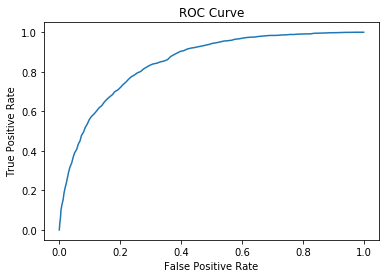

Area Under ROC: 0.849167641172105


In [21]:
lr_trainSummary = lr_model.summary
lr_roc = lr_trainSummary.roc.toPandas()
plt.plot(lr_roc['FPR'], lr_roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Area Under ROC:', str(lr_trainSummary.areaUnderROC))

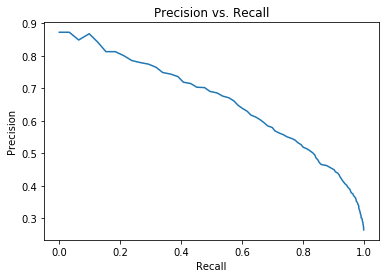

In [22]:
lr_precision_recall = lr_trainSummary.pr.toPandas()
plt.plot(lr_precision_recall['recall'], lr_precision_recall['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.show()

#### Model Evaluation

In [23]:
# Make predictions on test data

lr_predictions = lr_model.transform(test)
lr_predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(15)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[0.51550627726673...|       0.0|[0.62609638468795...|
|  0.0|[1.50624610890516...|       0.0|[0.81850421392118...|
|  0.0|[1.74504969619542...|       0.0|[0.85132733552880...|
|  0.0|[5.69054752201502...|       0.0|[0.99663362766653...|
|  0.0|[3.35808347540541...|       0.0|[0.96636854458227...|
|  1.0|[0.16211775307057...|       0.0|[0.54044090416227...|
|  0.0|[2.28895836825227...|       0.0|[0.90795843797758...|
|  0.0|[-0.2805829074494...|       1.0|[0.43031087433076...|
|  1.0|[2.76290941802526...|       0.0|[0.94063829820850...|
|  0.0|[1.35859401555247...|       0.0|[0.79553109338100...|
|  0.0|[3.04525330392601...|       0.0|[0.95457715514961...|
|  1.0|[0.24896487344433...|       0.0|[0.56192170458442...|
|  1.0|[-0.9982397947897...|       1.0|[0.26928763944041...|
|  0.0|[4.53825930860077

In [24]:
# Use BinaryClassificationEvaluator to evaluate our model. 
# Note that the default metric for the BinaryClassificationEvaluator is areaUnderROC

lr_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'label')
print('Test Area Under ROC:', lr_evaluator.evaluate(lr_predictions))

Test Area Under ROC: 0.8348739363543803


In [25]:
lr_predictionAndLabels = lr_predictions.select('prediction', 'label').rdd
lr_metrics = MulticlassMetrics(lr_predictionAndLabels)
print('Summary of Model Testing:')
print('Accuracy:', lr_metrics.accuracy)
print('Precision (1):', lr_metrics.precision(label = 1.0))
print('Recall (1):', lr_metrics.recall(label = 1.0))
print('F1 score (1):', lr_metrics.fMeasure(label = 1.0))

Summary of Model Testing:
Accuracy: 0.7811594202898551
Precision (1): 0.6265822784810127
Recall (1): 0.518324607329843
F1 score (1): 0.5673352435530087


#### Tuning the Model

Now we will try tuning the model with the ParamGridBuilder and the CrossValidator.

If you are unsure what params are available for tuning, you can use explainParams() to print a list of all params and their definitions.

In [26]:
# Check the params that can be tuned

# print(lr.explainParams())

In [27]:
# Create ParamGrid for cross-validation

lr_params_grid = (ParamGridBuilder() 
                 .addGrid(lr.regParam, [0, 0.01, 0.1, 1, 2]) 
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                 .build())

In [28]:
# Create and run k-fold cross validator. Choose the best set of parameters.

lr_cv = CrossValidator(estimator = lr, estimatorParamMaps = lr_params_grid, evaluator = lr_evaluator, numFolds = 5, 
                       seed = 0, parallelism = 4)
lr_cv_model = lr_cv.fit(train)

In [29]:
#  Use test set to measure the performance of our model on new data. Use the best model found 

lr_cv_predictions = lr_cv_model.transform(test)
print('Test Area Under ROC:', lr_evaluator.evaluate(lr_cv_predictions))

Test Area Under ROC: 0.8348739363543803


In [30]:
lr_cv_predictionAndLabels = lr_cv_predictions.select('prediction', 'label').rdd
lr_cv_metrics = MulticlassMetrics(lr_cv_predictionAndLabels)
print('Summary of Model Testing:')
print('Accuracy:', lr_cv_metrics.accuracy)
print('Precision (1):', lr_cv_metrics.precision(label = 1.0))
print('Recall (1):', lr_cv_metrics.recall(label = 1.0))
print('F1 score (1):', lr_cv_metrics.fMeasure(label = 1.0))

Summary of Model Testing:
Accuracy: 0.7811594202898551
Precision (1): 0.6265822784810127
Recall (1): 0.518324607329843
F1 score (1): 0.5673352435530087


In [31]:
# Print the parameters of the best model

print('regParam:', lr_cv_model.bestModel._java_obj.getRegParam())
print('elasticNetParam:', lr_cv_model.bestModel._java_obj.getElasticNetParam())

regParam: 0.0
elasticNetParam: 0.0


### 2.2 Random Forest

In [32]:
# Create model and train model with training data

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed = 0)
rf_model = rf.fit(train)

#### Model Evaluation

In [33]:
# Make predictions on test data

rf_predictions = rf_model.transform(test)
rf_predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(15)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[13.7942593633675...|       0.0|[0.68971296816837...|
|  0.0|[15.1774880278667...|       0.0|[0.75887440139333...|
|  0.0|[17.4376573550359...|       0.0|[0.87188286775179...|
|  0.0|[18.5850679529683...|       0.0|[0.92925339764841...|
|  0.0|[18.2755628819827...|       0.0|[0.91377814409913...|
|  1.0|[10.6106786525079...|       0.0|[0.53053393262539...|
|  0.0|[17.9357766257165...|       0.0|[0.89678883128582...|
|  0.0|[12.0388895205447...|       0.0|[0.60194447602723...|
|  1.0|[17.4638445996608...|       0.0|[0.87319222998304...|
|  0.0|[14.7799087611845...|       0.0|[0.73899543805923...|
|  0.0|[17.9589806775585...|       0.0|[0.89794903387792...|
|  1.0|[9.85888863295693...|       1.0|[0.49294443164784...|
|  1.0|[6.26880774515773...|       1.0|[0.31344038725788...|
|  0.0|[18.0900264180799

In [34]:
# Use BinaryClassificationEvaluator to evaluate our model. 
# Note that the default metric for the BinaryClassificationEvaluator is areaUnderROC

rf_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'label')
print('Test Area Under ROC:', rf_evaluator.evaluate(rf_predictions))

Test Area Under ROC: 0.8244814235801439


In [35]:
rf_predictionAndLabels = rf_predictions.select('prediction', 'label').rdd
rf_metrics = MulticlassMetrics(rf_predictionAndLabels)
print('Summary of Model Testing:')
print('Accuracy:', rf_metrics.accuracy)
print('Precision (1):', rf_metrics.precision(label = 1.0))
print('Recall (1):', rf_metrics.recall(label = 1.0))
print('F1 score (1):', rf_metrics.fMeasure(label = 1.0))

Summary of Model Testing:
Accuracy: 0.7681159420289855
Precision (1): 0.6396396396396397
Recall (1): 0.3717277486910995
F1 score (1): 0.47019867549668876


#### Tuning the Model

In [36]:
# Check the params that can be tuned

# print(rf.explainParams())

In [37]:
# Create ParamGrid for cross-validation

rf_params_grid = (ParamGridBuilder()
                 .addGrid(rf.maxDepth, [2, 4, 6])
                 .addGrid(rf.maxBins, [5, 20, 40])
                 .addGrid(rf.numTrees, [10, 20, 50, 100])
                 .build())

In [38]:
# Create and run k-fold cross validator

rf_cv = CrossValidator(estimator = rf, estimatorParamMaps = rf_params_grid, evaluator = rf_evaluator, numFolds = 5, 
                       seed = 0, parallelism = 4)
rf_cv_model = rf_cv.fit(train)

In [39]:
#  Use test set to measure the performance of our model on new data

rf_cv_predictions = rf_cv_model.transform(test)
print('Test Area Under ROC:', rf_evaluator.evaluate(rf_cv_predictions))

Test Area Under ROC: 0.8349054129200778


In [40]:
rf_cv_predictionAndLabels = rf_cv_predictions.select('prediction', 'label').rdd
rf_cv_metrics = MulticlassMetrics(rf_cv_predictionAndLabels)
print('Summary of Model Testing:')
print('Accuracy:', rf_cv_metrics.accuracy)
print('Precision (1):', rf_cv_metrics.precision(label = 1.0))
print('Recall (1):', rf_cv_metrics.recall(label = 1.0))
print('F1 score (1):', rf_cv_metrics.fMeasure(label = 1.0))

Summary of Model Testing:
Accuracy: 0.763768115942029
Precision (1): 0.625
Recall (1): 0.36649214659685864
F1 score (1): 0.46204620462046203


In [41]:
# Print the parameters of the best model

print('maxDepth:', rf_cv_model.bestModel._java_obj.getMaxDepth())
print('maxBins:', rf_cv_model.bestModel._java_obj.getMaxBins())
print('numTrees:', rf_cv_model.bestModel._java_obj.getNumTrees())

maxDepth: 6
maxBins: 40
numTrees: 50


## 3. Make Predictions

With the best areaUnderROC score, we will use the best model for deployment, and use it to generate predictions on new data. In this example, we will simulate this by generating predictions on the entire dataset.

In [42]:
best_model = lr_cv_model.bestModel

In [43]:
# Generate predictions for entire dataset

total_predictions = best_model.transform(df)

In [44]:
# Evaluate the best model

print('Area Under ROC for entire dataset:', lr_evaluator.evaluate(total_predictions))

Area Under ROC for entire dataset: 0.8478192000184137


## 4. Feature Importance

In [45]:
# get the list of feature names

feature_names = []
for i in df.schema['features'].metadata['ml_attr']['attrs']:
    for j in df.schema['features'].metadata['ml_attr']['attrs'][i]:
        feature_names.append(j['name'])

In [46]:
# Feature importance of logistic regression model

lr_feature_scores = lr_cv_model.bestModel.coefficients.toArray()
lr_feature_importance_df = pd.DataFrame(dict(feature = feature_names, score = lr_feature_scores))
lr_feature_importance_df = lr_feature_importance_df.iloc[lr_feature_importance_df['score'].abs().argsort()[::-1]].reset_index(drop = True)
print('Logistic Regression Feature Importance:')
lr_feature_importance_df

Logistic Regression Feature Importance:


,feature,score
0,InternetServiceOneHotVec_Fiber optic,3.259694
1,InternetServiceOneHotVec_DSL,1.609159
2,tenureScaled_0,-1.429527
3,MonthlyChargesScaled_0,-1.035961
4,ContractOneHotVec_Two year,-0.706661
5,TotalChargesScaled_0,0.658367
6,ContractOneHotVec_Month-to-month,0.632976
7,StreamingMoviesOneHotVec_No,-0.596254
8,StreamingTVOneHotVec_No,-0.525654
9,MultipleLinesOneHotVec_No,-0.397662


In [47]:
# Feature importance of random forest model

rf_feature_scores = rf_cv_model.bestModel.featureImportances.toArray()
rf_feature_importance_df = pd.DataFrame(dict(feature = feature_names, score = rf_feature_scores)) \
                                        .sort_values('score', ascending = False).reset_index(drop = True)
print('Random Forest Feature Importance:')
rf_feature_importance_df

Random Forest Feature Importance:


,feature,score
0,ContractOneHotVec_Month-to-month,0.224754
1,tenureScaled_0,0.210551
2,InternetServiceOneHotVec_Fiber optic,0.110734
3,MonthlyChargesScaled_0,0.090376
4,TotalChargesScaled_0,0.089020
5,PaymentMethodOneHotVec_Electronic check,0.077097
6,ContractOneHotVec_Two year,0.061942
7,PaperlessBillingOneHotVec_Yes,0.026461
8,InternetServiceOneHotVec_DSL,0.018398
9,OnlineSecurityOneHotVec_No,0.018349
